## Imports 


In [218]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# connect to Drive

In [272]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/POMCP_Experiments
!ls 

Mounted at /content/drive


# log file

Loading the log files that contains the experiments.
Each file contains the experiments on a specefic model (tag, rockSample..)

Each row represents a single experiment.

The log file columns -

*   **model**  - Model name
*   **solver** - The solver that was used
*   **depth**  - Maximum depth of search tree (search depth in the search phase)
*   **geometric_search_depth** - Relevent only for POMCP solver. If the value is set to 1 then the search depth in the search phase is drawn from a geometric distribution with P=1/depth 
*   **steps** - Number of steps in the model
*   **runs** - Number of simulation runs
*   **leaf_heuristic** - Relevent only for POMCP solver. The heuristic that is used to evaluate the leaf nodes.
Options - 
**  rollout - preforming defualt policy starting at the leaf state
**  SARSOP - using SARSOP value of the leaf state
**  VI - using Value Iteration value of the leaf state
*   **unsuccessful_reward** - Setting the reward of prefoming an action with an unsuccessful outcome. For example in tag model, preforming a tag action when the robot is not at the same grid as the opponent. value=-1e+10: the reward is set to be the default value in the model
*  **check_default_policy** - Relevent only for POMCP solver. When it is set to 1, pomcp preforms one length simulate and then does rollout for the rest of the search depth 
*  **drmean** - Mean of the discounted rewards
*  **drstd** - Standard error of the mean of the discounted rewards
*  **urmesn** - Mean of the undiscounted rewards
*  **urstd** - Standard error of the mean of the undiscounted rewards
*  **cputime** - Cpu time that took the experimnt to run in seconds


In [219]:
experiments = pd.read_csv('tag_noOppObs.log')

In [220]:
experiments.head(5)

,model,solver,depth,geometric_search_depth,steps,runs,leaf_heuristic,unsuccessful_reward,check_default_policy,drmean,drstd,urmean,urstd,cputime
0,N6despot11TagNoOppObsE,DESPOT,10,0,90,1,rollout,-1,0,-15.9417,0,-29,0,46.4335
1,N6despot11TagNoOppObsE,POMCP,10,0,90,1,rollout,-1,0,-13.2219,0,-19,0,34.2502
2,N6despot11TagNoOppObsE,POMCP,10,0,90,1,SARSOP,-1,0,-13.2219,0,-19,0,41.3698
3,N6despot11TagNoOppObsE,POMCP,10,0,90,1,VI,-1,0,-19.8022,0,-90,0,125.0570
4,N6despot11TagNoOppObsE,POMCP,10,0,90,1,rollout,-1,1,-19.3260,0,-64,0,75.0257


# Plot

In [222]:
def Plot_all_in_one(df):
  sns.scatterplot(data=df, x='experiment', y='drmean',hue='depth',palette=['green','orange','brown'])
  plt.xticks(rotation=90)
  plt.errorbar(df['experiment'], df['drmean'], yerr=df['drstd'],fmt='none')

In [223]:
def create_legend(df, color_palette):
  # Create legend names
  num_exp = df['experiment'].nunique()
  experiment_legend = [str(i) + ": " for i in range(1,num_exp + 1)] + df['experiment'].unique()
  # Create a color palette
  palette = dict(zip(experiment_legend, color_palette))
  # Create legend handles manually
  handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
  # Create legend
  plt.legend(handles=handles, loc='lower right')
  # Get current axes object and turn off axis
  plt.gca().set_axis_off()
  plt.show()

In [262]:
def set_row_title(axs, row_length, grouped):
  if row_length == 1: #only defualt reward
    return

  pad = 5
  #create one key for each row
  row_val = [f'r_notag={key[0]}' for i, key in enumerate(grouped.groups.keys()) if i%row_length == 0]
  for ax, row in zip(axs[:,0], row_val):
      ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
              xycoords=ax.yaxis.label, textcoords='offset points',
              size='large', ha='right', va='center', weight='bold', fontsize=14)  

In [268]:
def create_subplots(grouped, row_length, col_length, color_palette, title):

  fig, axs = plt.subplots(figsize=(col_length*4,row_length*4), 
                          nrows=row_length, ncols=col_length,     
                          gridspec_kw=dict(hspace=0.4), constrained_layout=True) 

  fig.suptitle(title, fontsize=20)
  targets = zip(grouped.groups.keys(), axs.flatten())
  for i, (key, ax) in enumerate(targets):
      ax.set_title('depth=%d'%key[1], weight='bold', fontsize=14) # Set column title
      ax.bar([1,2,3,4,5,6], grouped.get_group(key)['drmean'], yerr=3,ecolor='black', color = color_palette) #now hardcoded the std 
      #ax.bar([1,2,3,4,5,6], grouped.get_group(key)['drmean'], yerr=grouped.get_group(key)['drstd'],ecolor='black', color = color_palette)

  
  return axs
  

In [259]:
# create subplots per depth
def Plot(df, title): 
  
  color_palette = ['mediumpurple','lightskyblue','yellowgreen','khaki','peru','firebrick']
  create_legend(df, color_palette)

  row_length = df['unsuccessful_reward'].nunique()
  col_length = df['depth'].nunique()

  grouped = df.groupby(['unsuccessful_reward','depth'])
  

  axs = create_subplots(grouped, row_length, col_length, color_palette, title)
  
  set_row_title(axs, row_length, grouped)
  plt.setp(axs.flat, xlabel='Experiments', ylabel='drmean')
  
  plt.show()


In [227]:
# experiments["unsuccessful_reward"] = experiments["unsuccessful_reward"].astype(str)
# fig = px.scatter(experiments, x='experiment', y='drmean', color="unsuccessful_reward", error_y="drstd")

# fig.show()



In [279]:
def createDF_plot(file_name, title):
  experiments = pd.read_csv(file_name)
  experiments["experiment"] = experiments['solver'] +"-geometric:"+ experiments["geometric_search_depth"].astype(str) +"-"+ experiments["leaf_heuristic"] +"-default_policy:"+ experiments["check_default_policy"].astype(str)
  Plot(experiments, title) 

# Main

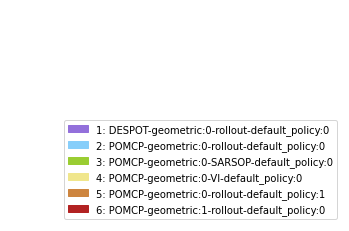

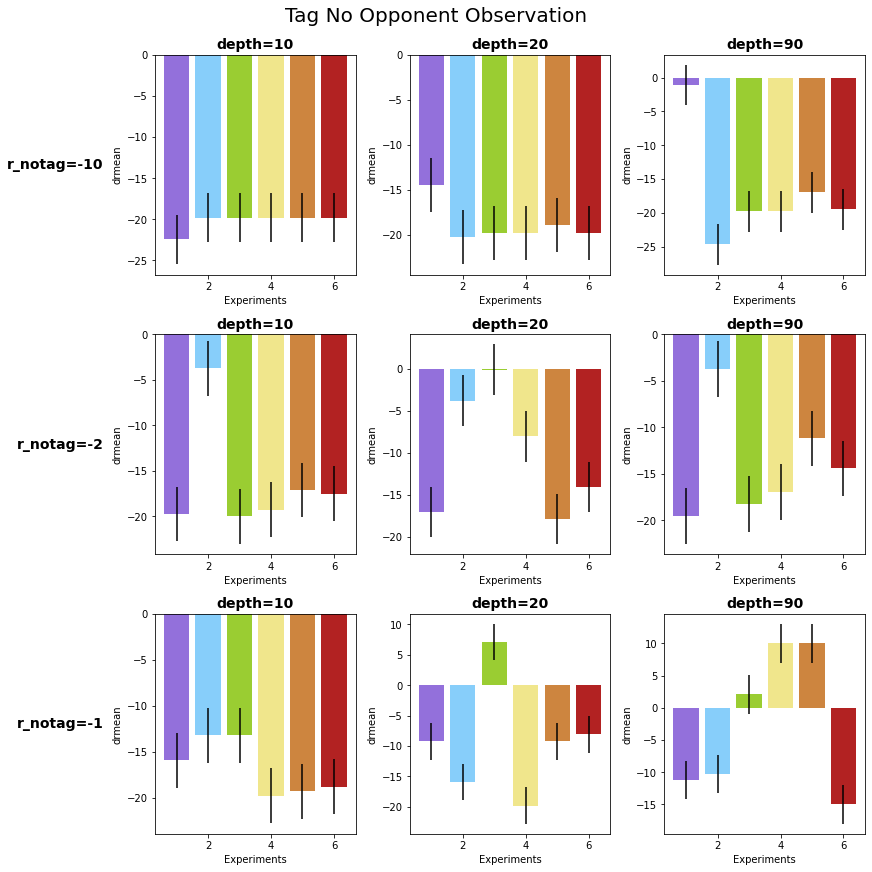

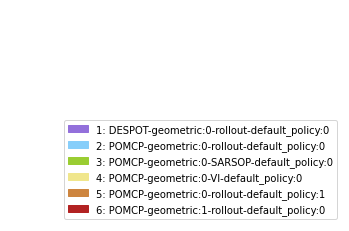

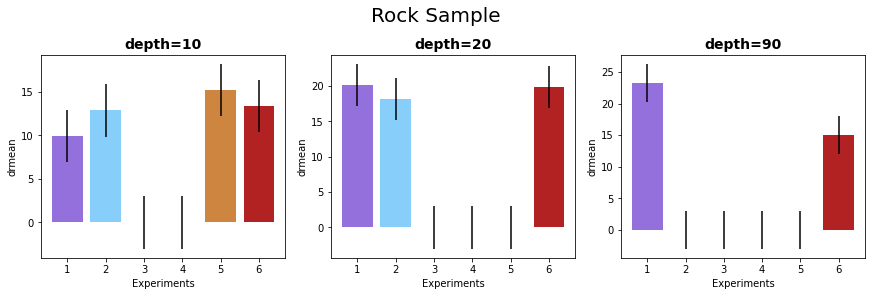

In [280]:
createDF_plot(file_name='tag_noOppObs.log', title="Tag No Opponent Observation")
createDF_plot(file_name='rock_sample.log', title="Rock Sample")
